### Calculate the Word Mover's Distance between two sentences

In [1]:
import gensim.downloader as api
import glob
import sys
import os
import pandas as pd

from tqdm import tqdm

sys.path.append("../../../../utils")
from absolute_path_builder import AbsolutePathBuilder

### Read demographic groups' sentences

In [2]:
twitter_datapath = AbsolutePathBuilder.get_path(
    "04_twitter_scored",
    filepaths="../../../../config/filepaths.yaml"
)

filenames = [file.split("/")[-1] for file in glob.glob(os.path.join(twitter_datapath, "*"))]

# Get the descriptions
data = []
for filename in filenames:
    description = {}
    
    description["filename"] = filename
    description["group"] = filename.split("_")[0]
    
    data.append(description)
    
df_data_desc = pd.DataFrame(data)

df_data_desc["group"] = (
    df_data_desc
    .group.apply(
        lambda group: "Black"
        if group=='aa'
        else "White"
    )
)

# Load data
dfs = []
for filename in df_data_desc[df_data_desc.group == "Black"].filename.values:
    try:
        df = pd.read_csv(os.path.join(twitter_datapath, filename))
        dfs.append(df)
    except:
        count += 1
df_black = pd.concat(dfs)

dfs = []
for filename in df_data_desc[df_data_desc.group == "White"].filename.values:
    try:
        df = pd.read_csv(os.path.join(twitter_datapath, filename))
        dfs.append(df)
    except:
        count += 1
df_white = pd.concat(dfs)

---
### Load embedding model

In [3]:
embedding_model = api.load("glove-wiki-gigaword-50")
# embedding_model = api.load("word2vec-google-news-300")

In [4]:
import numpy as np

data = []
distances = []
for _, row_white in tqdm(df_white.iterrows(), total=df_white.shape[0]):

    closest_row_black = None
    closest_dist = np.inf
    for _, row_black in df_black.iterrows():
        cur_distance = embedding_model.wmdistance(row_white.text, row_black.text)

        if(cur_distance < closest_dist):
            closest_dist = cur_distance
            closest_row_black = row_black

    closest_row_black.index = [f"{name}_black" for name in closest_row_black.index]
    concatenated_row = pd.concat([closest_row_black, row_white])
    
    data.append(concatenated_row)
    distances.append(closest_dist)

100%|███████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  6.96it/s]


In [5]:
df_wmd = pd.DataFrame(data)
df_wmd["wmd"] = distances

df_wmd = df_wmd.reset_index(drop=True)

In [6]:
output_path = AbsolutePathBuilder.get_path(
    f"07_word_mover_distance",
    filepaths="../../../../config/filepaths.yaml"
)

df_wmd.to_csv(os.path.join(output_path, "twitter_wmd.csv"), index=False)

/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


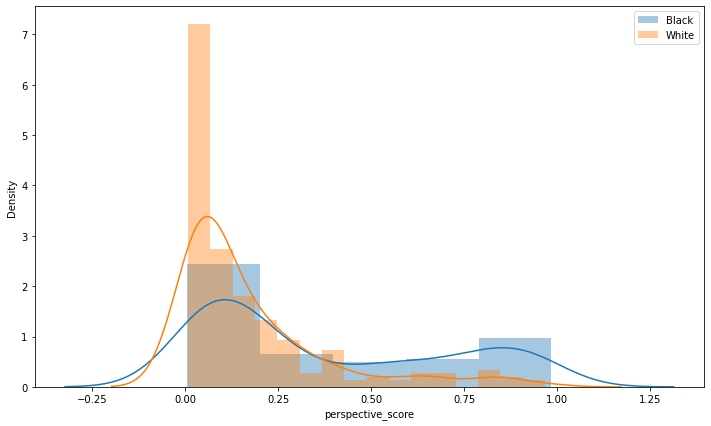

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(12,7))

sns.distplot(df_wmd.perspective_score_black, label="Black")
sns.distplot(df_wmd.perspective_score, label="White")

plt.legend()
plt.show()

/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


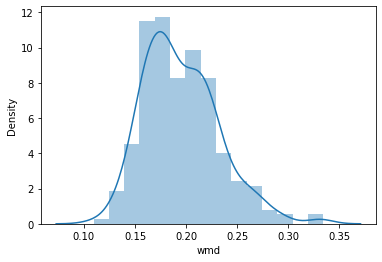

In [8]:
sns.distplot(df_wmd.wmd)
plt.title("")
plt.show()